# The Kyle Model

I'm indebted to Reiko for her help with this problem.

In [215]:
import pickle
import numpy as np
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime

The first thing to do is import the raw data - make sure you don't try to print any of this or jupyter *will* crash! Also make sure you manually save the data as a txt file.

In [3]:
AAPLraw = pickle.load(open('AAPL.txt', 'rb'))
Craw = pickle.load(open('C.txt', 'rb'))
GBXraw = pickle.load(open('GBX.txt', 'rb'))
SPYraw = pickle.load(open('SPY.txt', 'rb'))
THOraw = pickle.load(open('THO.txt', 'rb'))

In [301]:
class Orderbook:
    '''
    The orderbook class. Initialized with a single element of the raw data files.
    Methods:
        __init__: accepts the raw data and a name and cleans it up - the final form 
            is a dataframe with columns for price, quantity at that price, cumulative 
            quantity, and buy/sell side.
        estimate: estimates parameters γ and β for equation (10). I have two different 
            estimators, which limit the regression to subsets of the data only inculding bids
            within 15 pct and 5 pct of the observations
        plot: plots the orderbook with the two estimatorsoverlaid in the 15 pct region
    '''
    
    def __init__(self, data, name):
        self.time = data[0]
        self.name = name
        
        #Cleaning
        df = pd.DataFrame.from_dict(data[1], orient='index')
        df = df.sort_index()
        df = df.reset_index()
        df.columns = ['Price', 'Quantity', 'Side', 'X','Y']
        df = df.drop(['X', 'Y'], axis = 1)
        
        #Get cumulative quantity - setting 0 to where buy meets sell
        df['Cumulative_Quantity'] = df['Quantity'].cumsum()
        Qmkt = np.max(df['Cumulative_Quantity'][df['Side']== 'B'])
        Pmkt = df['Price'][(df['Cumulative_Quantity'][df['Side']== 'B']).idxmax()]
        df['Cumulative_Quantity'] = df['Cumulative_Quantity'] - Qmkt
        # Save Price as attribute
        self.Pmkt = Pmkt
        
        #Restrict to region where most of the quantity moves
        
        #Save data and some subsets as attributes
        self.data = df
        self.data15P = df[(df.Price >= self.Pmkt*.85) 
                               & (df.Price <= self.Pmkt*1.15)]
        self.data05P = df[(df.Price >= self.Pmkt*.95) 
                               & (df.Price <= self.Pmkt*1.05)]

        
    def estimate(self, orderbook):
        result = smf.ols(formula='Cumulative_Quantity ~ Price', data=orderbook).fit()
        gamma, beta = result.params[0], result.params[1]
        return result.params
    
    def plot(self):
        #Plot orderbook
        plt.plot(self.data15P['Price'], self.data15P['Cumulative_Quantity'],\
                 label = 'Orderbook data')
        
        #Get 2 different estimators
        
        result05P = self.estimate(self.data05P)
        gamma05P, beta05P = result05P[0], result05P[1]
        est05P = gamma05P + beta05P * self.data15P.Price
        
        result15P = self.estimate(self.data15P)
        gamma15P, beta15P = result15P[0], result15P[1]
        est15P = gamma15P + beta15P * self.data15P.Price
        
        #Plot estimators
        plt.plot(self.data15P.Price, est15P, label = f'Approximation within 15% of P \n \
(using middle 50th pctile) \n gamma = {np.round(gamma15P)} \n beta = {np.round(beta15P)}')
        plt.plot(self.data15P.Price, est05P, label = f'Approximation within 5% of P \n gamma = {np.round(gamma05P)} \
\n beta = {np.round(beta05P)}')
        plt.legend(loc = 'center left', bbox_to_anchor = (0, .8))
        plt.title(f'Order Book of {self.name} at time {self.time}')
        plt.xlabel('Price')
        plt.ylabel('Cumulative Quantity')
        plt.xlim(self.data15P.Price.min(), self.data15P.Price.max())
        plt.ylim(self.data15P.Cumulative_Quantity.min() * 1.1, self.data15P.Cumulative_Quantity.max() * 1.1)
        
        

## Part 1

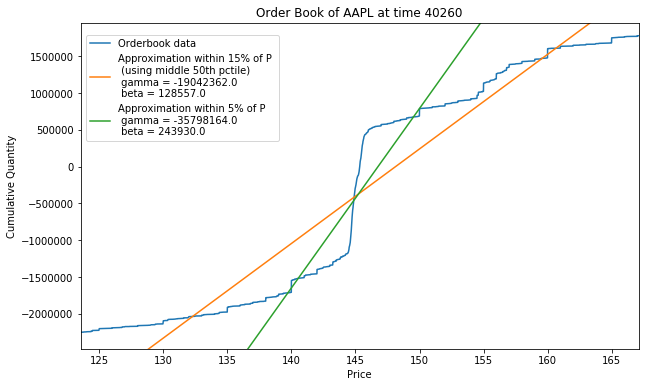

In [302]:
book = Orderbook(AAPLraw[100], 'AAPL')
fig = plt.subplots(figsize = (10, 6))
book.plot()

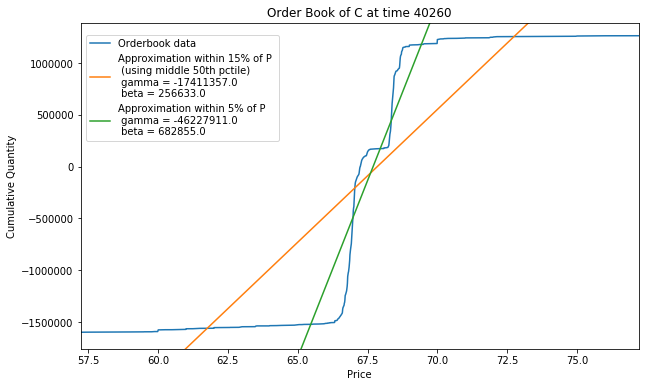

In [303]:
book = Orderbook(Craw[100], 'C')
fig = plt.subplots(figsize = (10, 6))
book.plot()

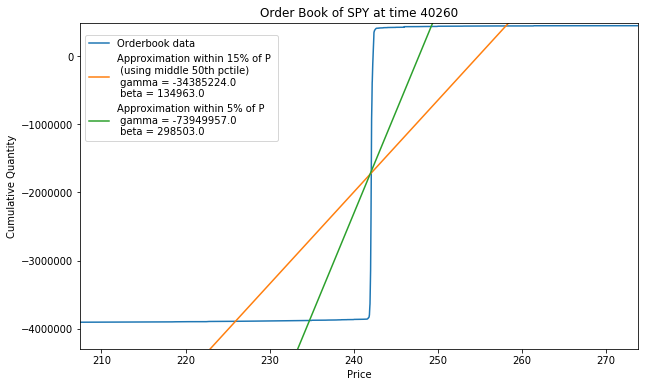

In [304]:
book = Orderbook(SPYraw[100], 'SPY')
fig = plt.subplots(figsize = (10, 6))
book.plot()

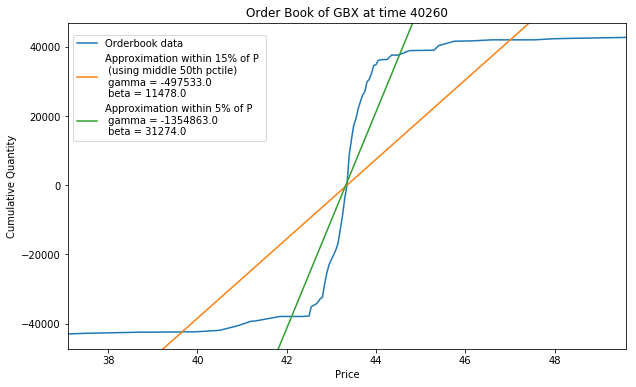

In [305]:
book = Orderbook(GBXraw[100], 'GBX')
fig = plt.subplots(figsize = (10, 6))
book.plot()

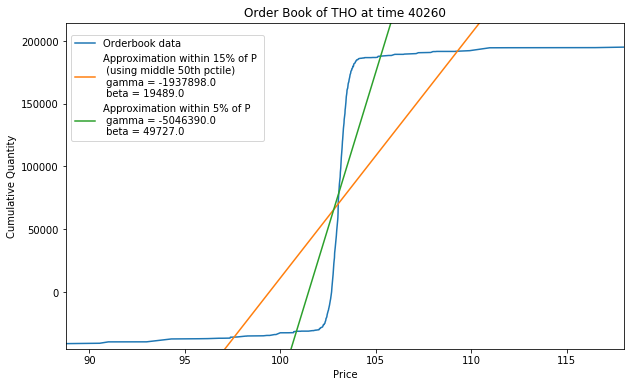

In [306]:
book = Orderbook(THOraw[100], 'THO')
fig = plt.subplots(figsize = (10, 6))
book.plot()

In [307]:
class Assetday():
    '''
    This class is initialized with a raw data dictionary from the NASDAQ ITCH files,
    cleans the data into individual data-frames and is equipped with some nice plotting 
    methods which span the whole day.
    Methods:
        init:
            initializes data series for the ticker. Accepts raw data and a name which is 
            printed on the graphs. Create series for times, market price, and ratio/imputed 
            price for each estimate. 
        signoiseplot:
            Plots time series of noise/signal estimators for each estimator
        priceestplot: 
            Plots market price and price estimators over time
    '''
    
    def __init__(self, rawdata, name):
        #Initialize attributes
        self.prices = []
        self.times = []
        self.ratio05Ps = []
        self.ratio15Ps = []
        self.Pimputed05s = []
        self.Pimputed15s = []
        self.name = name
        for i in range(len(rawdata)):
            book = Orderbook(rawdata[i], name)
            
            #Get ratios and imputed prices
            result05P = book.estimate(book.data05P)
            gamma05P, beta05P = result05P[0], result05P[1]
            Pimputed05 = -gamma05P / beta05P 
            
            result15P = book.estimate(book.data15P)
            gamma15P, beta15P = result15P[0], result15P[1]
            Pimputed15 = -gamma15P / beta15P
            
            self.prices.append(book.Pmkt)
            self.times.append(book.time)
            self.ratio05Ps.append(beta05P)
            self.ratio15Ps.append(beta15P)
            self.Pimputed05s.append(Pimputed05)
            self.Pimputed15s.append(Pimputed15)
            
    def signoiseplot(self):
        fig = plt.subplots(figsize = (10, 6))
        plt.plot(self.times, self.ratio05Ps, label = 'Approximation Within 5 Pct of P')
        plt.plot(self.times, self.ratio15Ps, label = 'Approximation Within 15 Pct of P')
        plt.xlabel('Time (seconds after midnight)')
        plt.ylabel('Noise/Signal Ratio')
        plt.legend(loc = 'center left', bbox_to_anchor = (0, .9))
        plt.title(f'Market Maker Beliefs About Composition of Investor Pool Over Time for {self.name}')
        
    def priceestplot(self):
        fig = plt.subplots(figsize = (10, 6))
        plt.plot(self.times, self.prices, label = 'Market Price')
        plt.plot(self.times, self.Pimputed15s, label = 'Imputed price - Within 15% of P')
        plt.plot(self.times, self.Pimputed05s, label = 'Imputed price - Within 5% of P')
        plt.xlabel('Time (seconds after midnight)')
        plt.ylabel('Price (USD)')
        plt.legend(loc = 'center left', bbox_to_anchor = (0, .9))
        plt.title(f'Comparison of Model-Imputed price and actual price for {self.name}')

In [308]:
AAPLAD = Assetday(AAPLraw, 'AAPL')
CAD = Assetday(Craw, 'C')
SPYAD = Assetday(SPYraw, 'SPY')
GBXAD = Assetday(GBXraw, 'GBX')
THOAD = Assetday(THOraw, 'THO')

## Part 2

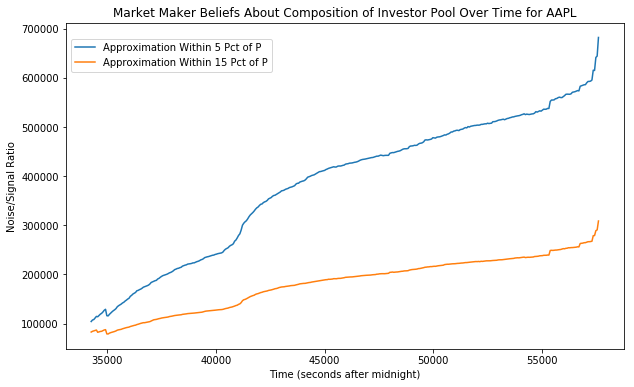

In [309]:
AAPLAD.signoiseplot()

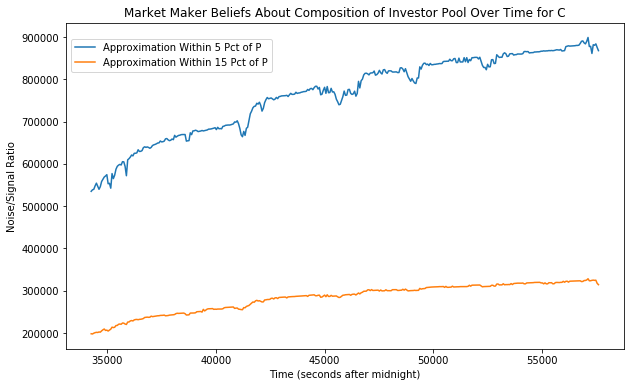

In [310]:
CAD.signoiseplot()

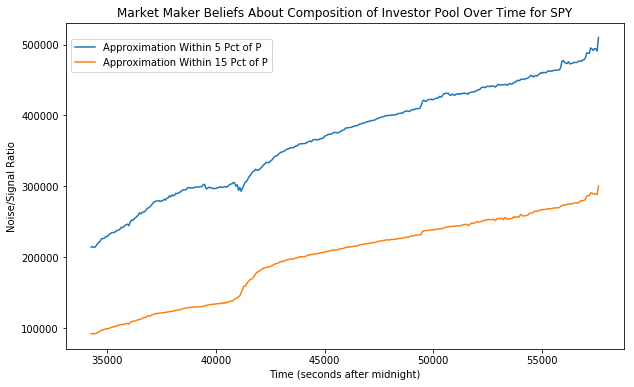

In [311]:
SPYAD.signoiseplot()

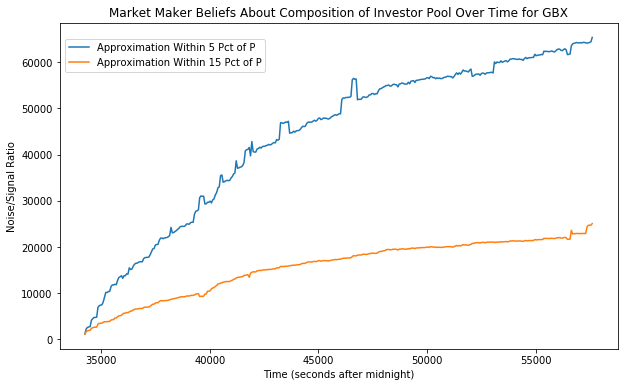

In [312]:
GBXAD.signoiseplot()

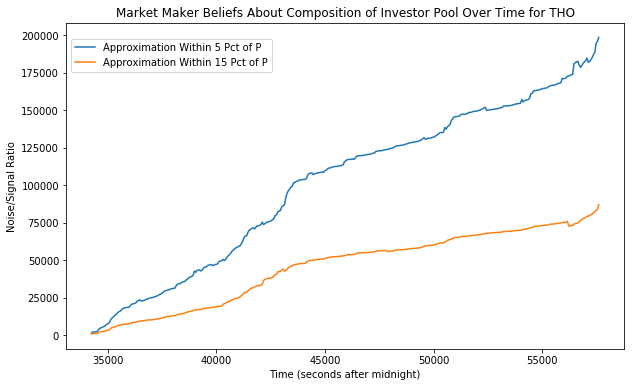

In [313]:
THOAD.signoiseplot()

## Part 3

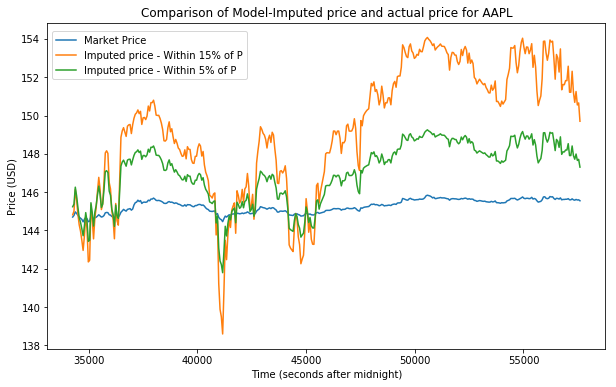

In [296]:
AAPLAD.priceestplot()

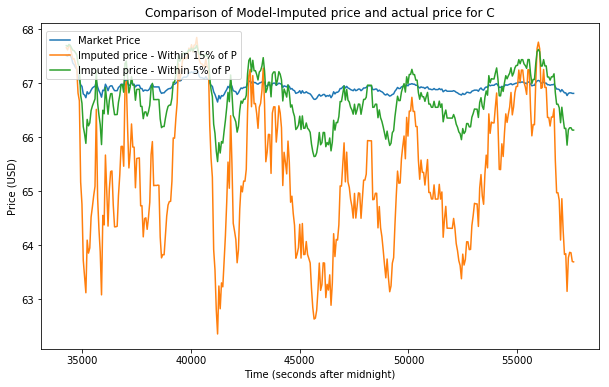

In [297]:
CAD.priceestplot()

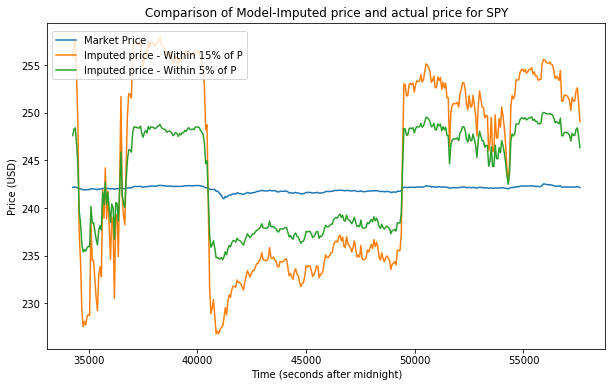

In [298]:
SPYAD.priceestplot()

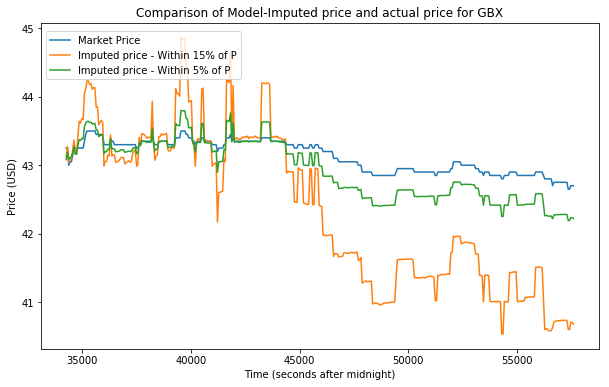

In [299]:
GBXAD.priceestplot()

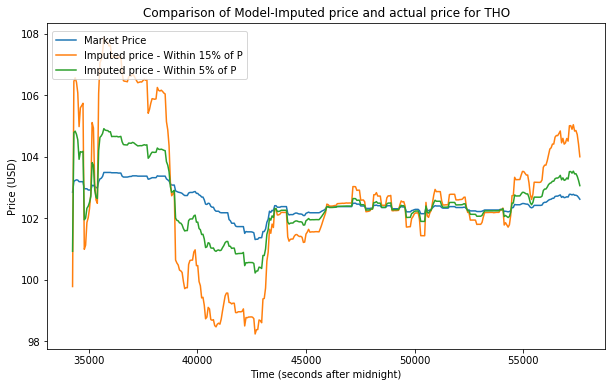

In [300]:
THOAD.priceestplot()

## Part 4

In general, the green estimators (within 5 % of P) are the better estimators of the market price, which suggests that I should use these instead of the orange ones - indeed, it might be beneficial even to make the window smaller.

The noise to signal ratio generally increased over the day. This makes some level of sense - one might think that more informed traders are the ones making bids early in the morning, and the rest of the market "eases in" to it a bit more.